In [1]:
import datetime as dt

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (16,6) # (32,12)

In [2]:
from sklearn.preprocessing import MinMaxScaler

In [3]:
import preprocessing_data

In [13]:
# 'data/csv/oving5/0141126194/Partner.csv'
# 'data/csv/oving5/0141126194/Card.csv'
df = preprocessing_data.get_df_from_csv('data/csv/oving5/1395669706/Partner.csv')

In [4]:
# Perfectly executed
df = preprocessing_data.get_df_from_csv('data/csv/oving5/1120155961/Partner.csv')

In [19]:
# Brukt mye debug tool
df = preprocessing_data.get_df_from_csv('data/csv/oving5/2877527733/Partner.csv')

In [20]:
df.isnull().sum()

SourceEdit1                26
SizeMeasure1               26
WarningCount1              26
SourceEdit_ErrorCount1     26
StoredString1              46
Start1                     28
End1                       28
Launch1                    96
JunitTest1                122
FailureCount1             122
Completion1               122
SuccessCount1             122
JunitTest_ErrorCount1     122
dtype: int64

In [21]:
preprocessing_data.patching_source_code(df)

# Experiments

In [22]:
preprocessing_data.fill_nan_columns(df)
preprocessing_data.create_relative_time_column(df)
preprocessing_data.aggregate_columns(df)

c:\users\herman\appdata\local\conda\conda\envs\jexercise\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


## Experiment #2
Using the **df** from earlier!

In [23]:
df

,SourceEdit1,SizeMeasure1,WarningCount1,SourceEdit_ErrorCount1,StoredString1,Start1,End1,Launch1,JunitTest1,FailureCount1,...,Active_time,SourceEdit,JunitTest,Launch,TotalSizeMeasure,TotalCompletion,TotalJunitTest_ErrorCount,TotalSourceEdit_ErrorCount,TotalErrorCount,TotalRuns
2017-02-23 14:35:18,1.0,-1.0,-1.0,-1.0,NaN,NaN,NaN,0.0,0.0,0.0,...,2017-02-23 14:35:18,1,0,0,-1.0,0.0,0.0,-1.0,-1.0,0
2017-02-23 14:35:38,1.0,5.0,0.0,0.0,package objectstructures;\r\n\r\npublic class ...,NaN,NaN,0.0,0.0,0.0,...,2017-02-23 14:35:38,1,0,0,5.0,0.0,0.0,0.0,0.0,0
2017-02-23 14:35:49,1.0,7.0,0.0,0.0,\t\r\n\t,51.0,-4.0,0.0,0.0,0.0,...,2017-02-23 14:35:49,1,0,0,7.0,0.0,0.0,0.0,0.0,0
2017-02-23 14:41:31,1.0,27.0,2.0,1.0,/**\r\n\t * Felt:\r\n\t */\r\n\tprivate final ...,52.0,-8.0,0.0,0.0,0.0,...,2017-02-23 14:41:31,1,0,0,27.0,0.0,0.0,1.0,1.0,0
2017-02-23 14:41:55,1.0,26.0,2.0,1.0,NaN,325.0,-14.0,0.0,0.0,0.0,...,2017-02-23 14:41:55,1,0,0,26.0,0.0,0.0,1.0,1.0,0
2017-02-23 14:42:35,1.0,34.0,0.0,1.0,}\r\n\r\n\t\r\n\tpublic String getName() {\r\n...,325.0,-10.0,0.0,0.0,0.0,...,2017-02-23 14:42:35,1,0,0,34.0,0.0,0.0,1.0,1.0,0
2017-02-23 14:43:32,1.0,39.0,0.0,1.0,public void setPartner(Partner partner) {\r\n\t\t,444.0,-13.0,0.0,0.0,0.0,...,2017-02-23 14:43:32,1,0,0,39.0,0.0,0.0,1.0,1.0,0
2017-02-23 14:43:59,1.0,39.0,0.0,0.0,.,300.0,-198.0,0.0,0.0,0.0,...,2017-02-23 14:43:59,1,0,0,39.0,0.0,0.0,0.0,0.0,0
2017-02-23 14:45:07,1.0,40.0,0.0,0.0,:\r\n\t * Èn for bare navn (og får da default;...,156.0,-343.0,0.0,0.0,0.0,...,2017-02-23 14:45:07,1,0,0,40.0,0.0,0.0,0.0,0.0,0
2017-02-23 14:45:48,1.0,51.0,0.0,0.0,/**\r\n * \r\n * @author HenrietteAndersen\r\n...,26.0,-120.0,0.0,0.0,0.0,...,2017-02-23 14:45:48,1,0,0,51.0,0.0,0.0,0.0,0.0,0


In [18]:
not_debugging = slice(None, '2017-02-22 20:09:02')
debugging = slice('2017-02-22 20:09:02', '2017-02-22 22:20:32')
completed = slice('2017-02-22 22:20:32', None)

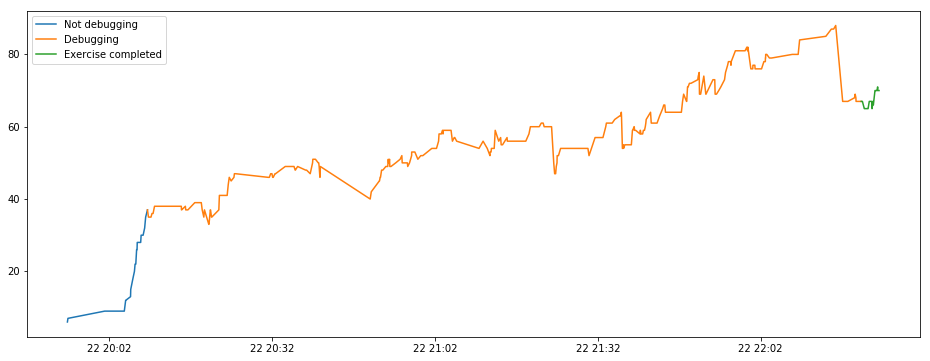

In [19]:
plt.figure(figsize=(16,6))
plt.plot(df[not_debugging].SizeMeasure1, label='Not debugging')
plt.plot(df[debugging].SizeMeasure1, label='Debugging')
plt.plot(df[completed].SizeMeasure1, label='Exercise completed')
plt.legend()

In [20]:
df['TotalRuns'] = df.JunitTest + df.Launch

In [21]:
# Char diff
df['Char_diff_between_runs'] = np.nan
df['Acc_char_diff_between_runs'] = np.nan

df['Char_diff_between_5min_runs'] = np.nan
df['Acc_char_diff_between_5min_runs'] = np.nan

df['Char_diff_between_5min_runs_all'] = np.nan
df['Acc_char_diff_between_5min_runs_all'] = np.nan

# Line diff
df['Line_diff_between_runs'] = np.nan
df['Acc_line_diff_between_runs'] = np.nan

df['Line_diff_between_5min_runs'] = np.nan
df['Acc_line_diff_between_5min_runs'] = np.nan

df['Line_diff_between_5min_runs_all'] = np.nan
df['Acc_line_diff_between_5min_runs_all'] = np.nan

# Completion
df['Completion_diff_between_5min_runs'] = np.nan
df['Completion_diff_between_5min_runs_all'] = np.nan

df['Runs_between_5min_runs'] = np.nan
df['Runs_between_5min_runs_all'] = np.nan

In [22]:
only_runs = df[df.TotalRuns == 1]

In [23]:
# Character diff between two runs
for i in range(1, len(only_runs)):
    prev_row = only_runs.iloc[i - 1]
    cur_row = only_runs.iloc[i]
    df.Char_diff_between_runs.at[cur_row.name] = preprocessing_data.get_diff_length(prev_row.SourceCode1, cur_row.SourceCode1)
    df.Line_diff_between_runs.at[cur_row.name] = preprocessing_data.get_diff_length_lines(prev_row.SourceCode1,
                                                                                          cur_row.SourceCode1)

In [24]:
window_start = only_runs.iloc[0].name
for i2 in range(1, len(only_runs)):
    cur_row = only_runs.iloc[i2]
    if cur_row.name - window_start >= dt.timedelta(seconds=5*60):
        prev_row = only_runs.loc[window_start]
        df.Char_diff_between_5min_runs.at[cur_row.name] = preprocessing_data.get_diff_length(prev_row.SourceCode1,
                                                                            cur_row.SourceCode1)
        df.Line_diff_between_5min_runs.at[cur_row.name] = preprocessing_data.get_diff_length_lines(prev_row.SourceCode1,
                                                                            cur_row.SourceCode1)
        window_start = cur_row.name
        
        # Completion
        df.Completion_diff_between_5min_runs.at[cur_row.name] = cur_row.Completion1 - prev_row.Completion1
        
        # Run freq
        df.Runs_between_5min_runs.at[cur_row.name] = len(only_runs.loc[prev_row.name:cur_row.name]) - 2

In [25]:
period = dt.timedelta(seconds=5 * 60)

In [26]:
# Defining the start index as the first run 5 minutes after the first run.
# 'backfill' makes sure it picks the next index, i.e. greater than 5 minutes if no exact match
start_idx = only_runs.index.get_loc(only_runs.index[0] + period, method='backfill')

In [27]:
for i3 in range(start_idx, len(only_runs)):
    cur_row = only_runs.iloc[i3]
    # We get the first (oldest) run which is at least 5 minutes earlier
    prev_row = only_runs.iloc[only_runs.index.get_loc(only_runs.index[i3] - period, method='pad')]
    df.Char_diff_between_5min_runs_all.at[cur_row.name] = preprocessing_data.get_diff_length(prev_row.SourceCode1,
                                                                                             cur_row.SourceCode1)
    df.Line_diff_between_5min_runs_all.at[cur_row.name] = preprocessing_data.get_diff_length_lines(prev_row.SourceCode1,
                                                                                                   cur_row.SourceCode1)
    # Completion
    df.Completion_diff_between_5min_runs_all.at[cur_row.name] = cur_row.Completion1 - prev_row.Completion1
    
    # Run freq
    df.Runs_between_5min_runs_all.at[cur_row.name] = len(only_runs.loc[prev_row.name:cur_row.name]) - 2

In [28]:
# Accumulated character diff between runs
cumsum = 0
cumsum_lines = 0
for j in range(0, len(df)):
    # We keep the sum of character diff since the last run
    if not pd.isnull(df.Character_diff1.iat[j]):
        cumsum += df.Character_diff1.iat[j]
        cumsum_lines += df.Line_diff1.iat[j]
    if df.TotalRuns.iat[j] == 1:
        df.Acc_char_diff_between_runs.iat[j] = cumsum
        df.Acc_line_diff_between_runs.iat[j] = cumsum_lines
        cumsum = 0
        cumsum_lines = 0

In [29]:
window_start = only_runs.iloc[0].name
cumsum = 0
cumsum_lines = 0
for j2 in range(df.index.get_loc(window_start) + 1, len(df)):
    cur_row = df.iloc[j2]
    if not pd.isnull(cur_row.Character_diff1):
        cumsum += cur_row.Character_diff1
        cumsum_lines += cur_row.Line_diff1
    # Checking if there is a run on the current row and there has been at least 5 minutes since last run:
    if cur_row.TotalRuns == 1 and cur_row.name - window_start >= dt.timedelta(seconds=5*60):
        df.Acc_char_diff_between_5min_runs.at[cur_row.name] = cumsum
        df.Acc_line_diff_between_5min_runs.at[cur_row.name] = cumsum_lines
        cumsum = 0
        cumsum_lines = 0
        window_start = cur_row.name

In [30]:
for j3 in range(start_idx, len(only_runs)):
    cur_row = only_runs.iloc[j3]
    # We get the first (oldest) run which is at least 5 minutes earlier
    prev_row = only_runs.iloc[only_runs.index.get_loc(only_runs.index[j3] - period, method='pad')]
    acc_char_diff = df.loc[prev_row.name:cur_row.name].Character_diff1.sum()
    acc_line_diff = df.loc[prev_row.name:cur_row.name].Line_diff1.sum()
    df.Acc_char_diff_between_5min_runs_all.at[cur_row.name] = acc_char_diff
    df.Acc_line_diff_between_5min_runs_all.at[cur_row.name] = acc_line_diff

In [31]:
only_runs = df[df.TotalRuns == 1]

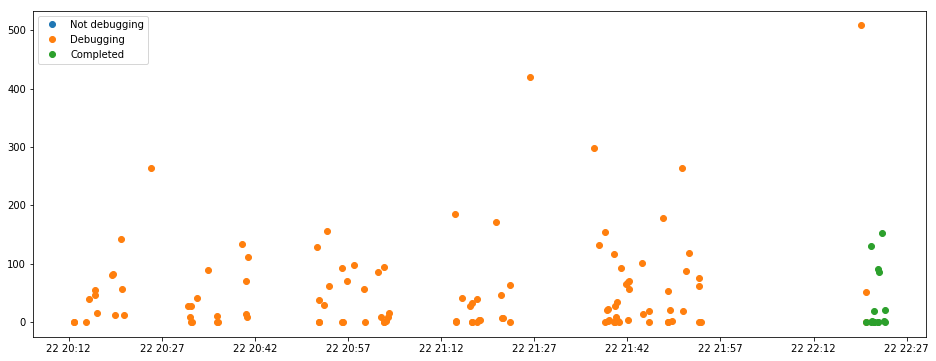

In [32]:
plt.figure(figsize=(16,6))
plt.plot(only_runs[not_debugging].Char_diff_between_runs, marker='o', linestyle="None", label='Not debugging')
plt.plot(only_runs[debugging].Char_diff_between_runs, marker='o', linestyle="None", label='Debugging')
plt.plot(only_runs[completed].Char_diff_between_runs, marker='o', linestyle="None", label='Completed')
plt.legend()

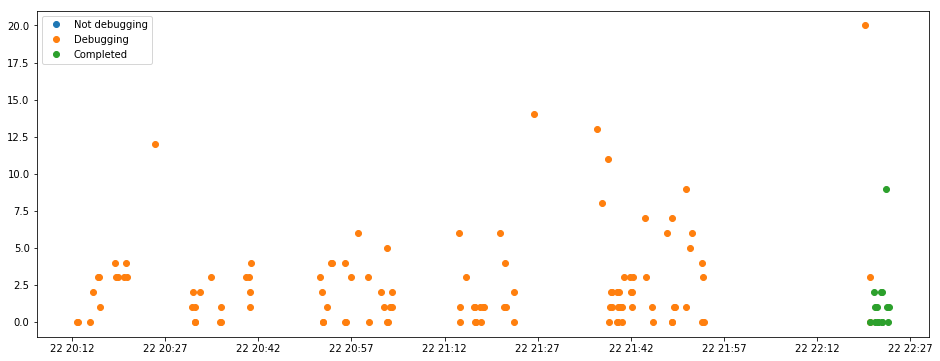

In [33]:
plt.figure(figsize=(16,6))
plt.plot(only_runs[not_debugging].Line_diff_between_runs, marker='o', linestyle="None", label='Not debugging')
plt.plot(only_runs[debugging].Line_diff_between_runs, marker='o', linestyle="None", label='Debugging')
plt.plot(only_runs[completed].Line_diff_between_runs, marker='o', linestyle="None", label='Completed')
plt.legend()

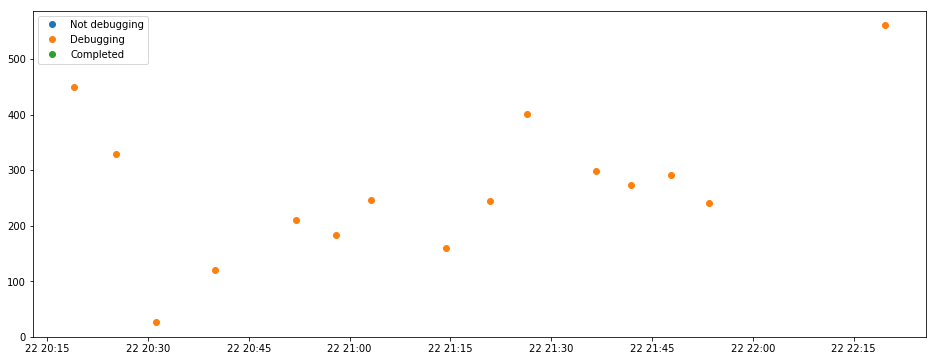

In [34]:
plt.figure(figsize=(16,6))
plt.plot(only_runs[not_debugging].Char_diff_between_5min_runs, marker='o', linestyle="None", label='Not debugging')
plt.plot(only_runs[debugging].Char_diff_between_5min_runs, marker='o', linestyle="None", label='Debugging')
plt.plot(only_runs[completed].Char_diff_between_5min_runs, marker='o', linestyle="None", label='Completed')
plt.legend()

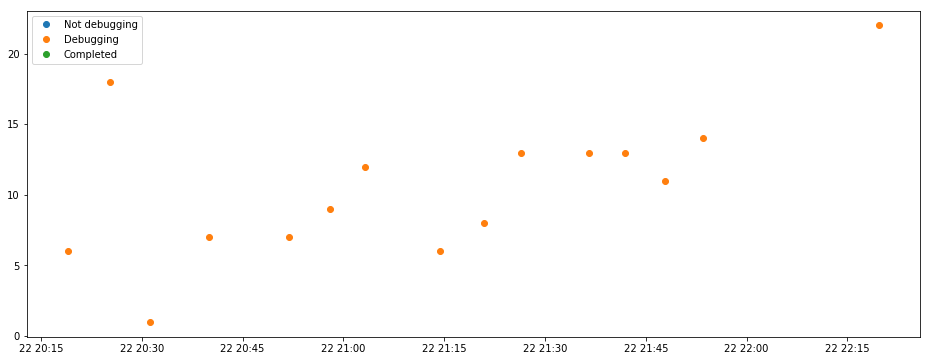

In [35]:
plt.figure(figsize=(16,6))
plt.plot(only_runs[not_debugging].Line_diff_between_5min_runs, marker='o', linestyle="None", label='Not debugging')
plt.plot(only_runs[debugging].Line_diff_between_5min_runs, marker='o', linestyle="None", label='Debugging')
plt.plot(only_runs[completed].Line_diff_between_5min_runs, marker='o', linestyle="None", label='Completed')
plt.legend()

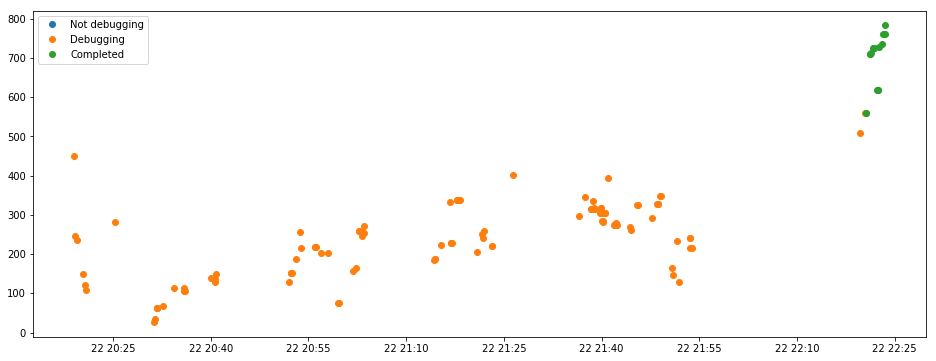

In [36]:
plt.figure(figsize=(16,6))
plt.plot(only_runs[not_debugging].Char_diff_between_5min_runs_all, marker='o', linestyle="None", label='Not debugging')
plt.plot(only_runs[debugging].Char_diff_between_5min_runs_all, marker='o', linestyle="None", label='Debugging')
plt.plot(only_runs[completed].Char_diff_between_5min_runs_all, marker='o', linestyle="None", label='Completed')
plt.legend()

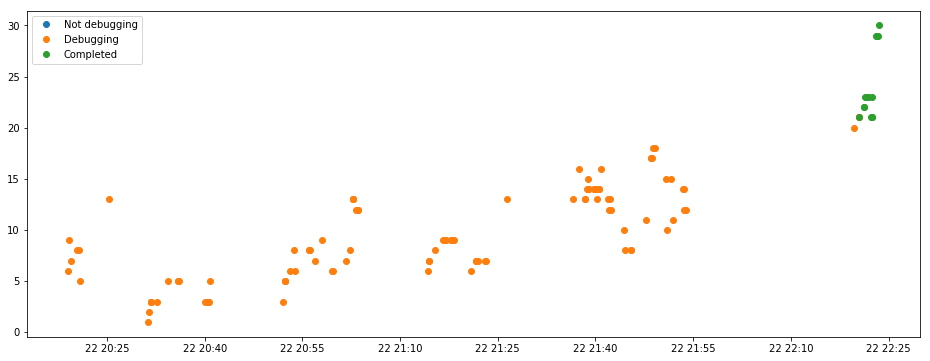

In [37]:
plt.figure(figsize=(16,6))
plt.plot(only_runs[not_debugging].Line_diff_between_5min_runs_all, marker='o', linestyle="None", label='Not debugging')
plt.plot(only_runs[debugging].Line_diff_between_5min_runs_all, marker='o', linestyle="None", label='Debugging')
plt.plot(only_runs[completed].Line_diff_between_5min_runs_all, marker='o', linestyle="None", label='Completed')
plt.legend()

### Accumulated character difference

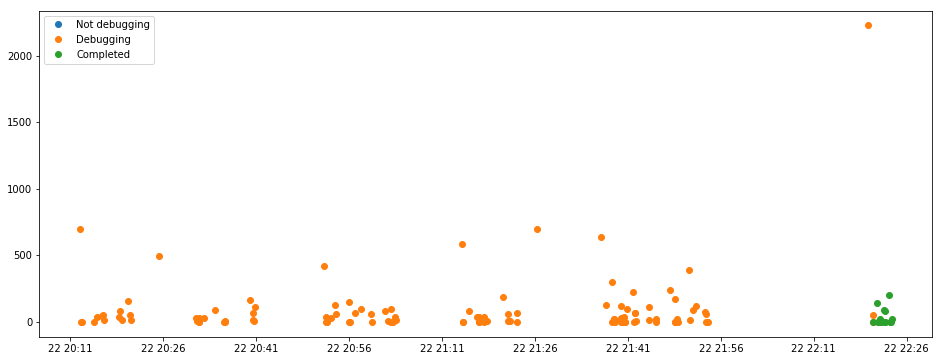

In [38]:
plt.figure(figsize=(16,6))
plt.plot(only_runs[not_debugging].Acc_char_diff_between_runs, marker='o', linestyle="None", label='Not debugging')
plt.plot(only_runs[debugging].Acc_char_diff_between_runs, marker='o', linestyle="None", label='Debugging')
plt.plot(only_runs[completed].Acc_char_diff_between_runs, marker='o', linestyle="None", label='Completed')
plt.legend()

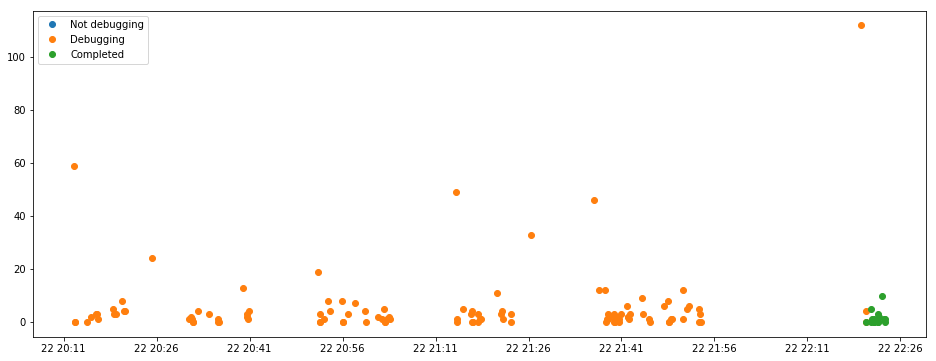

In [39]:
plt.figure(figsize=(16,6))
plt.plot(only_runs[not_debugging].Acc_line_diff_between_runs, marker='o', linestyle="None", label='Not debugging')
plt.plot(only_runs[debugging].Acc_line_diff_between_runs, marker='o', linestyle="None", label='Debugging')
plt.plot(only_runs[completed].Acc_line_diff_between_runs, marker='o', linestyle="None", label='Completed')
plt.legend()

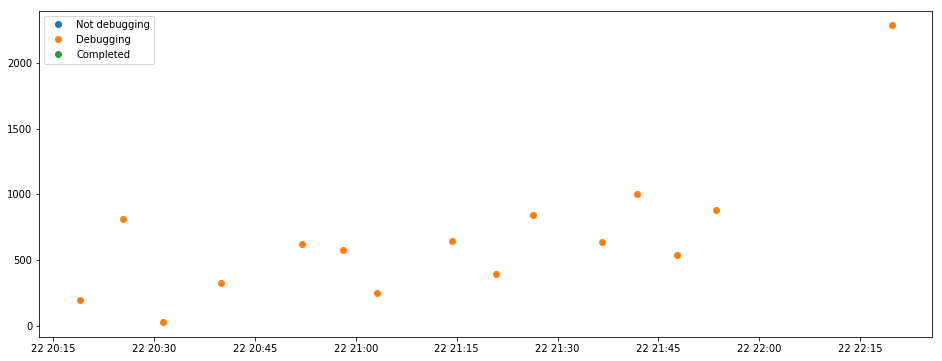

In [40]:
plt.figure(figsize=(16,6))
plt.plot(only_runs[not_debugging].Acc_char_diff_between_5min_runs, marker='o', linestyle="None", label='Not debugging')
plt.plot(only_runs[debugging].Acc_char_diff_between_5min_runs, marker='o', linestyle="None", label='Debugging')
plt.plot(only_runs[completed].Acc_char_diff_between_5min_runs, marker='o', linestyle="None", label='Completed')
plt.legend()

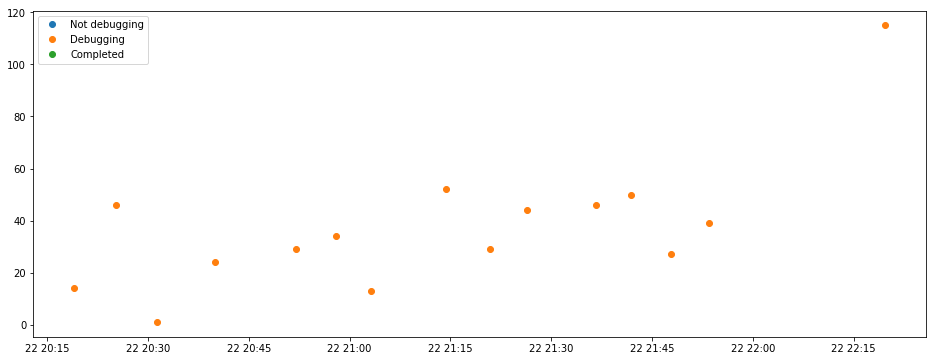

In [41]:
plt.figure(figsize=(16,6))
plt.plot(only_runs[not_debugging].Acc_line_diff_between_5min_runs, marker='o', linestyle="None", label='Not debugging')
plt.plot(only_runs[debugging].Acc_line_diff_between_5min_runs, marker='o', linestyle="None", label='Debugging')
plt.plot(only_runs[completed].Acc_line_diff_between_5min_runs, marker='o', linestyle="None", label='Completed')
plt.legend()

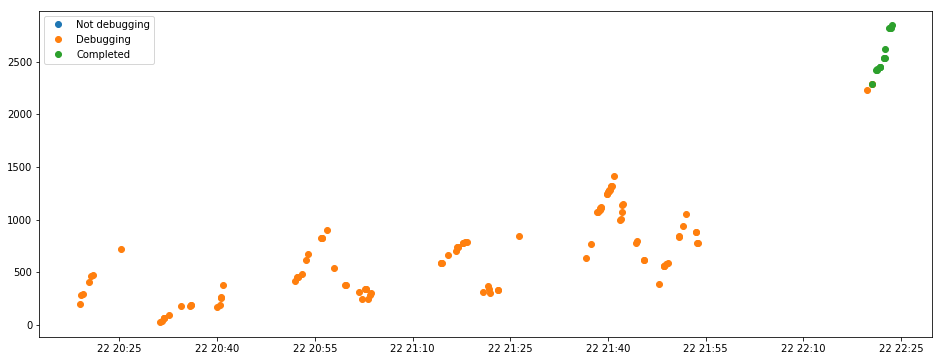

In [42]:
plt.figure(figsize=(16,6))
plt.plot(only_runs[not_debugging].Acc_char_diff_between_5min_runs_all, marker='o', linestyle="None", label='Not debugging')
plt.plot(only_runs[debugging].Acc_char_diff_between_5min_runs_all, marker='o', linestyle="None", label='Debugging')
plt.plot(only_runs[completed].Acc_char_diff_between_5min_runs_all, marker='o', linestyle="None", label='Completed')
plt.legend()

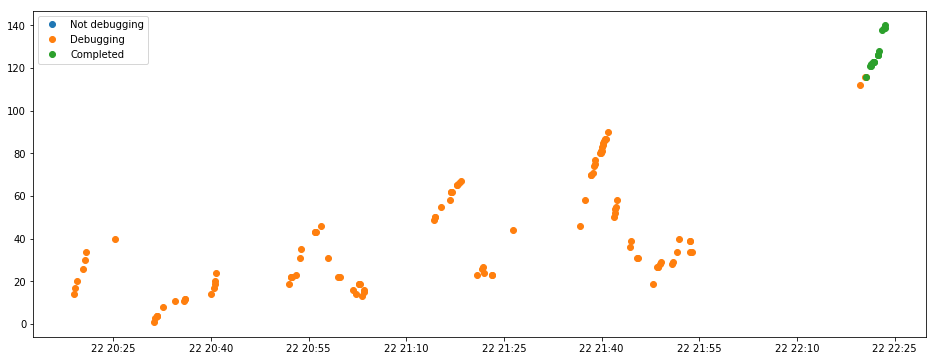

In [43]:
plt.figure(figsize=(16,6))
plt.plot(only_runs[not_debugging].Acc_line_diff_between_5min_runs_all, marker='o', linestyle="None", label='Not debugging')
plt.plot(only_runs[debugging].Acc_line_diff_between_5min_runs_all, marker='o', linestyle="None", label='Debugging')
plt.plot(only_runs[completed].Acc_line_diff_between_5min_runs_all, marker='o', linestyle="None", label='Completed')
plt.legend()

## Combined plots

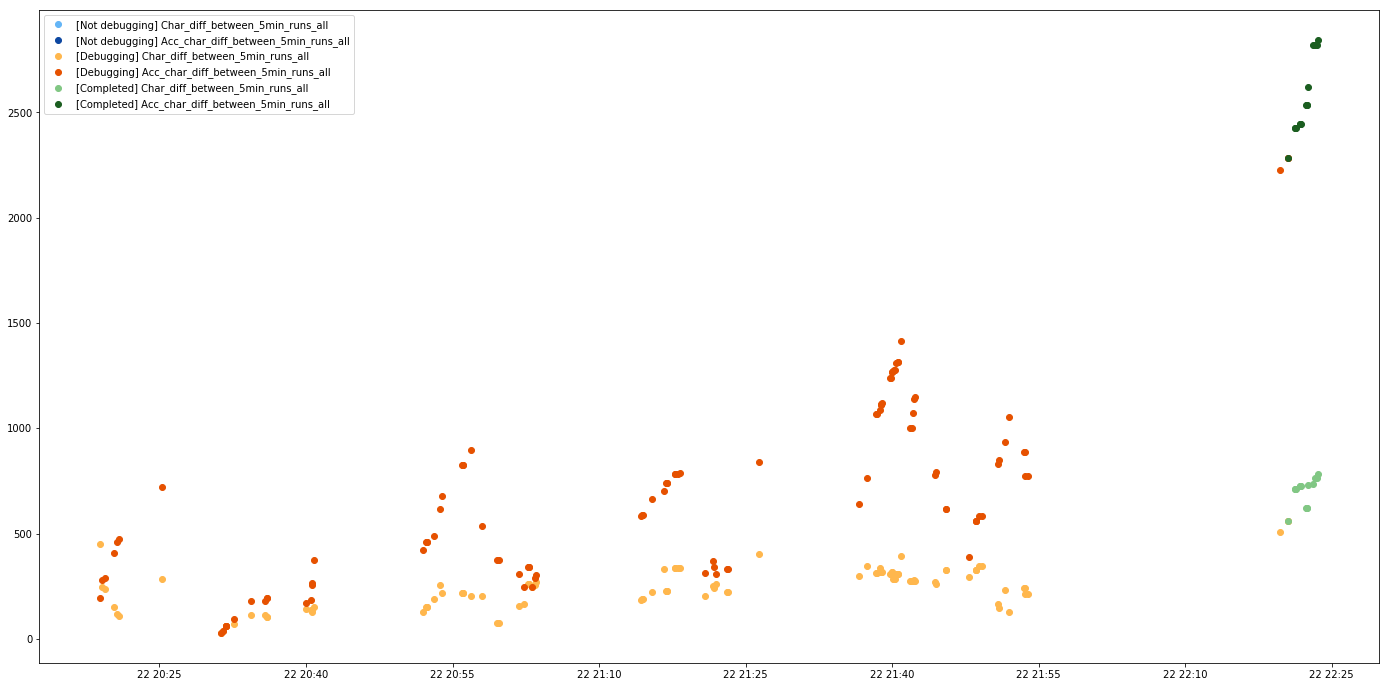

In [44]:
plt.figure(figsize=(24,12))
plt.plot(only_runs[not_debugging].Char_diff_between_5min_runs_all, marker='o',
         color="#64B5F6", linestyle="None", label='[Not debugging] Char_diff_between_5min_runs_all')
plt.plot(only_runs[not_debugging].Acc_char_diff_between_5min_runs_all, marker='o',
         color="#0D47A1", linestyle="None", label='[Not debugging] Acc_char_diff_between_5min_runs_all')
plt.plot(only_runs[debugging].Char_diff_between_5min_runs_all, marker='o',
         color="#FFB74D", linestyle="None", label='[Debugging] Char_diff_between_5min_runs_all')
plt.plot(only_runs[debugging].Acc_char_diff_between_5min_runs_all, marker='o',
         color="#E65100", linestyle="None", label='[Debugging] Acc_char_diff_between_5min_runs_all')
plt.plot(only_runs[completed].Char_diff_between_5min_runs_all, marker='o',
         color="#81C784", linestyle="None", label='[Completed] Char_diff_between_5min_runs_all')
plt.plot(only_runs[completed].Acc_char_diff_between_5min_runs_all, marker='o',
         color="#1B5E20", linestyle="None", label='[Completed] Acc_char_diff_between_5min_runs_all')

plt.legend()

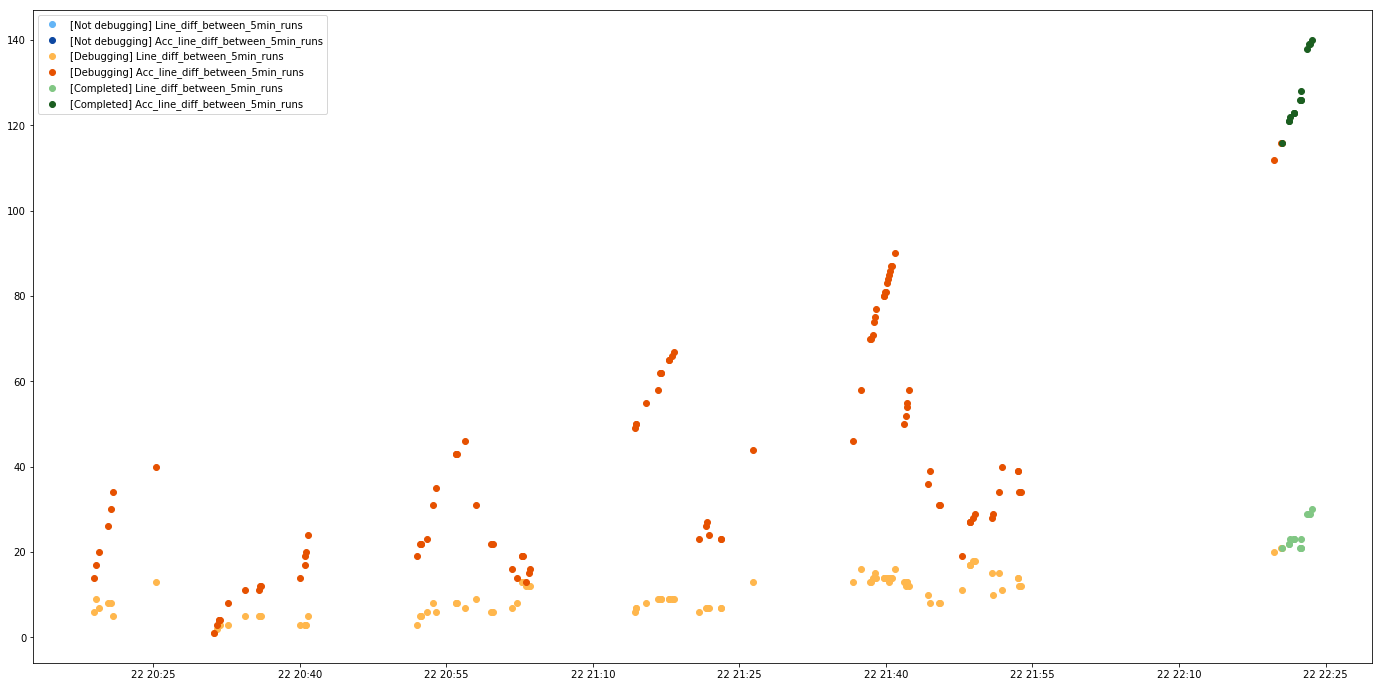

In [45]:
plt.figure(figsize=(24,12))
plt.plot(only_runs[not_debugging].Line_diff_between_5min_runs_all, marker='o',
         color="#64B5F6", linestyle="None", label='[Not debugging] Line_diff_between_5min_runs')
plt.plot(only_runs[not_debugging].Acc_line_diff_between_5min_runs_all, marker='o',
         color="#0D47A1", linestyle="None", label='[Not debugging] Acc_line_diff_between_5min_runs')
plt.plot(only_runs[debugging].Line_diff_between_5min_runs_all, marker='o',
         color="#FFB74D", linestyle="None", label='[Debugging] Line_diff_between_5min_runs')
plt.plot(only_runs[debugging].Acc_line_diff_between_5min_runs_all, marker='o',
         color="#E65100", linestyle="None", label='[Debugging] Acc_line_diff_between_5min_runs')
plt.plot(only_runs[completed].Line_diff_between_5min_runs_all, marker='o',
         color="#81C784", linestyle="None", label='[Completed] Line_diff_between_5min_runs')
plt.plot(only_runs[completed].Acc_line_diff_between_5min_runs_all, marker='o',
         color="#1B5E20", linestyle="None", label='[Completed] Acc_line_diff_between_5min_runs')

plt.legend()

### Runs between

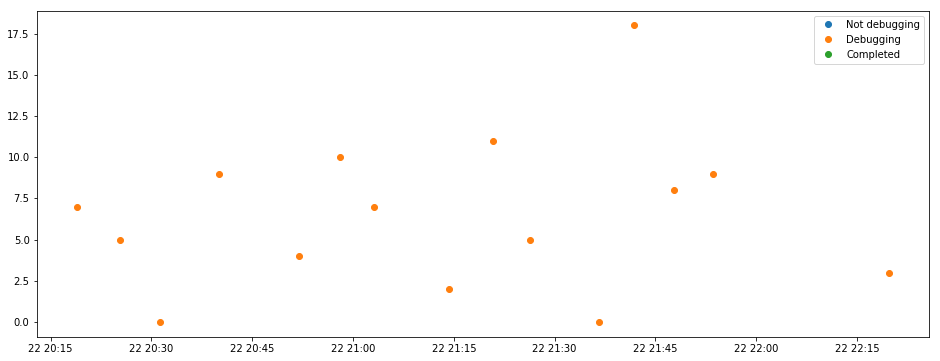

In [46]:
plt.figure(figsize=(16,6))
plt.plot(only_runs[not_debugging].Runs_between_5min_runs, marker='o', linestyle="None", label='Not debugging')
plt.plot(only_runs[debugging].Runs_between_5min_runs, marker='o', linestyle="None", label='Debugging')
plt.plot(only_runs[completed].Runs_between_5min_runs, marker='o', linestyle="None", label='Completed')
plt.legend()

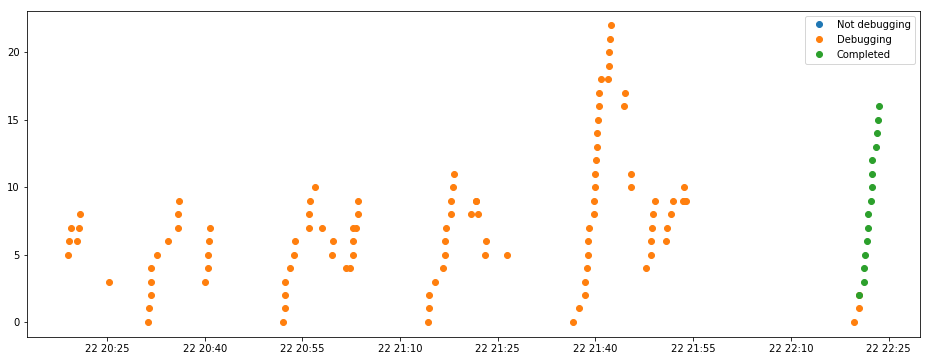

In [47]:
plt.figure(figsize=(16,6))
plt.plot(only_runs[not_debugging].Runs_between_5min_runs_all, marker='o', linestyle="None", label='Not debugging')
plt.plot(only_runs[debugging].Runs_between_5min_runs_all, marker='o', linestyle="None", label='Debugging')
plt.plot(only_runs[completed].Runs_between_5min_runs_all, marker='o', linestyle="None", label='Completed')
plt.legend()

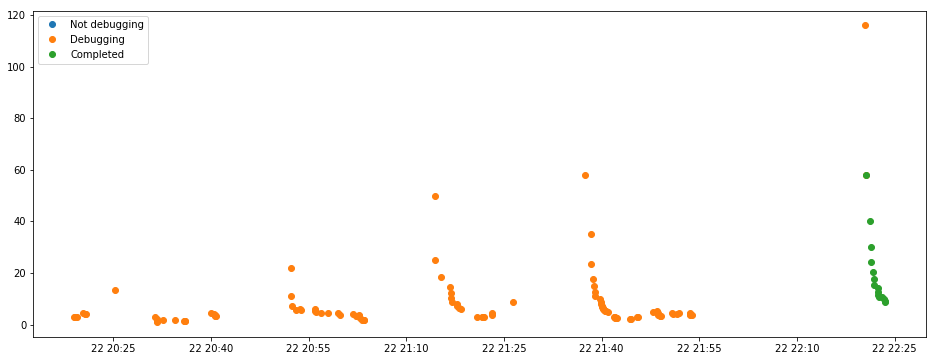

In [48]:
plt.figure(figsize=(16,6))
plt.plot(only_runs[not_debugging].Acc_line_diff_between_5min_runs_all / only_runs[not_debugging].Runs_between_5min_runs_all, marker='o', linestyle="None", label='Not debugging')
plt.plot(only_runs[debugging].Acc_line_diff_between_5min_runs_all / only_runs[debugging].Runs_between_5min_runs_all, marker='o', linestyle="None", label='Debugging')
plt.plot(only_runs[completed].Acc_line_diff_between_5min_runs_all / only_runs[completed].Runs_between_5min_runs_all, marker='o', linestyle="None", label='Completed')
plt.legend()

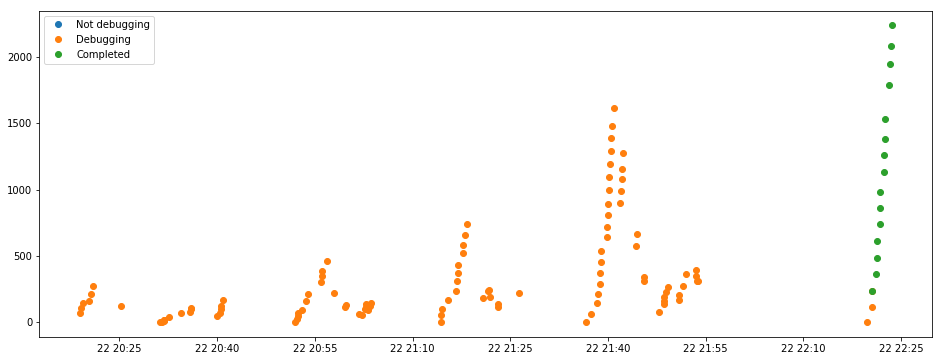

In [49]:
plt.figure(figsize=(16,6))
plt.plot(only_runs[not_debugging].Acc_line_diff_between_5min_runs_all * only_runs[not_debugging].Runs_between_5min_runs_all, marker='o', linestyle="None", label='Not debugging')
plt.plot(only_runs[debugging].Acc_line_diff_between_5min_runs_all * only_runs[debugging].Runs_between_5min_runs_all, marker='o', linestyle="None", label='Debugging')
plt.plot(only_runs[completed].Acc_line_diff_between_5min_runs_all * only_runs[completed].Runs_between_5min_runs_all, marker='o', linestyle="None", label='Completed')
plt.legend()

### Completion

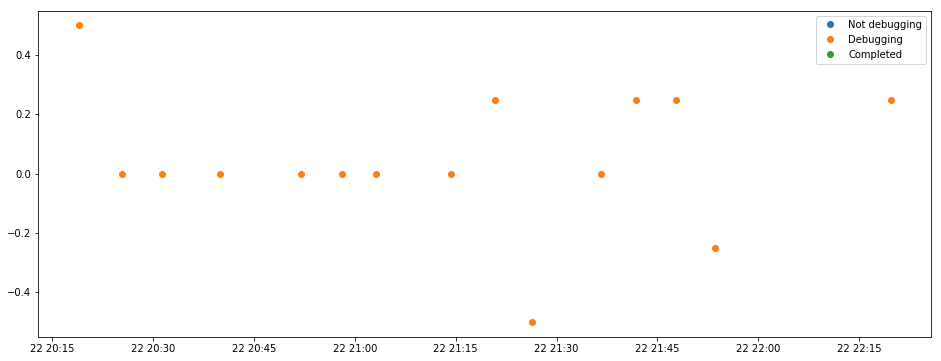

In [50]:
plt.figure(figsize=(16,6))
plt.plot(only_runs[not_debugging].Completion_diff_between_5min_runs, marker='o', linestyle="None", label='Not debugging')
plt.plot(only_runs[debugging].Completion_diff_between_5min_runs, marker='o', linestyle="None", label='Debugging')
plt.plot(only_runs[completed].Completion_diff_between_5min_runs, marker='o', linestyle="None", label='Completed')
plt.legend()

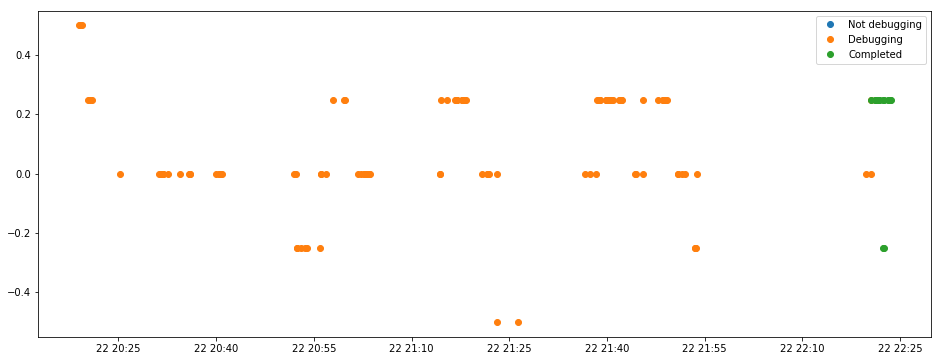

In [51]:
plt.figure(figsize=(16,6))
plt.plot(only_runs[not_debugging].Completion_diff_between_5min_runs_all, marker='o', linestyle="None", label='Not debugging')
plt.plot(only_runs[debugging].Completion_diff_between_5min_runs_all, marker='o', linestyle="None", label='Debugging')
plt.plot(only_runs[completed].Completion_diff_between_5min_runs_all, marker='o', linestyle="None", label='Completed')
plt.legend()

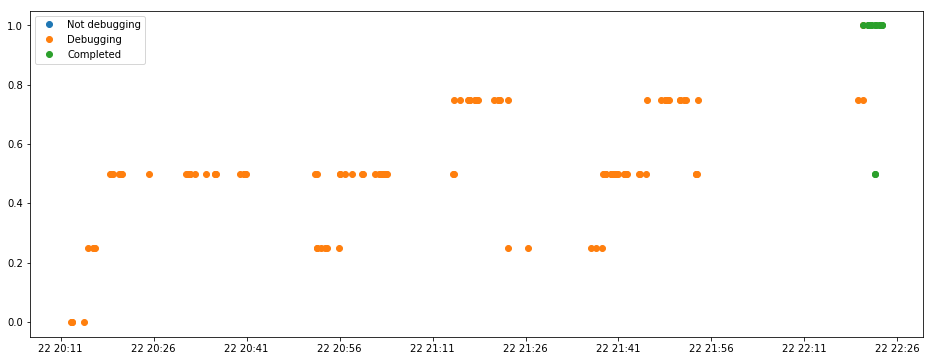

In [52]:
plt.figure(figsize=(16,6))
plt.plot(only_runs[not_debugging].Completion1, marker='o', linestyle="None", label='Not debugging')
plt.plot(only_runs[debugging].Completion1, marker='o', linestyle="None", label='Debugging')
plt.plot(only_runs[completed].Completion1, marker='o', linestyle="None", label='Completed')
plt.legend()

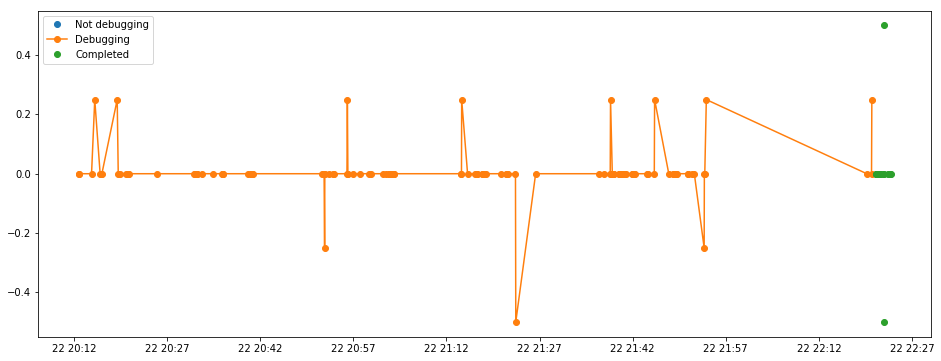

In [53]:
plt.figure(figsize=(16,6))
plt.plot(only_runs[not_debugging].Completion1.diff(), marker='o', linestyle="None", label='Not debugging')
plt.plot(only_runs[debugging].Completion1.diff(), marker='o', label='Debugging')
plt.plot(only_runs[completed].Completion1.diff(), marker='o', linestyle="None", label='Completed')
plt.legend()

## Accumulated / point diff and number of runs

In [24]:
preprocessing_data.classify_struggling(df)

2
1.0
2
1.3333333333333333
2
1.6666666666666667
2
1.3333333333333333
0
2.066666666666667
0
1.8421052631578947
0
1.894736842105263
0
1.9473684210526316
0
2.0
0
2.0526315789473686
0
2.1052631578947367
0
2.05
1
2.05
1
0
1
1.0
2
1.0
3
0
4
0
5
0
3
1.0
3
1.2
3
2.75
3
2.75
3
2.6
3
2.142857142857143
4
2.142857142857143
4
1.0
5
1.0
4
1.0
5
1.0
5
0
5
1.0
5
1.0
5
1.0
6
1.0
6
1.0
7
1.0
6
1.0
6
1.0
7
1.0
6
0
6
1.0
6
1.1333333333333333
6
1.3571428571428572
4
1.2941176470588236
4
1.6
5
1.6
4
1.0
5
1.0
5
1.0
3
1.0
3
1.0
3
1.0
4
1.0
4
1.0
3
1.0
3
1.0
2
1.0
3
1.0
4
1.0
2
2.0
2
2.0
3
2.0
1
1.0
1
0
2
0
1
1.0
1
1.2
1
1.2
1
1.6
2
1.6
2
1.0
3
1.0
2
1.0
3
1.0
3
1.0
3
2.0
4
2.0
4
1.0
4
1.0909090909090908
4
1.1818181818181819
4
1.2727272727272727
4
1.2142857142857142
4
1.75
5
1.75
5
1.0
5
1.0
5
1.0
6
1.0
6
1.0
6
1.0
7
1.0


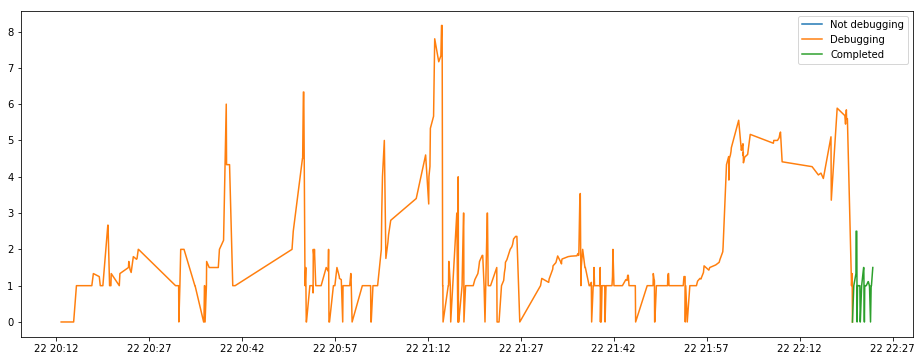

In [55]:
plt.figure(figsize=(16,6))
plt.plot(df[not_debugging].acc_div_point, label='Not debugging')
plt.plot(df[debugging].acc_div_point, label='Debugging')
plt.plot(df[completed].acc_div_point, label='Completed')
plt.legend()

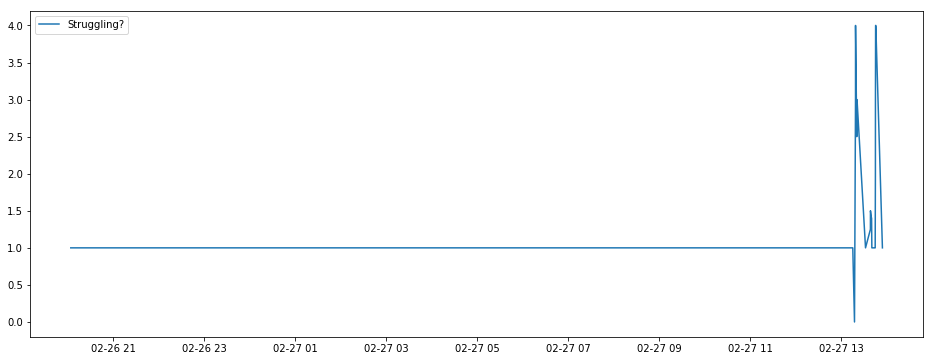

In [10]:
plt.figure(figsize=(16,6))
plt.plot(df.acc_div_point, label='Struggling?')
plt.legend()

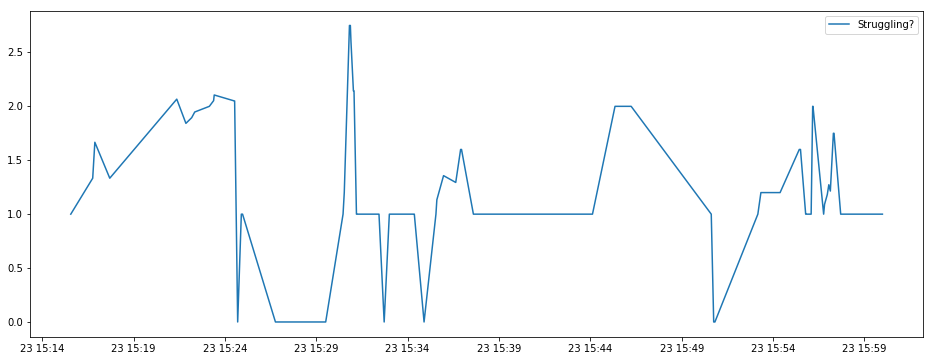

In [25]:
plt.figure(figsize=(16,6))
plt.plot(df.acc_div_point, label='Struggling?')
plt.legend()

In [11]:
df.acc_div_point.describe()

count    28.000000
mean      1.716071
std       1.114305
min       0.000000
25%       1.000000
50%       1.000000
75%       2.625000
max       4.000000
Name: acc_div_point, dtype: float64

In [12]:
df.runs_last_5mins.describe()

count    28.000000
mean      1.714286
std       1.863035
min       0.000000
25%       0.000000
50%       1.000000
75%       4.000000
max       5.000000
Name: runs_last_5mins, dtype: float64

In [26]:
scaled_df = preprocessing_data.scale_data(df[['acc_div_point', 'runs_last_5mins']].fillna(0))

In [27]:
df['scaled_max'] = scaled_df.max(axis=1)

In [28]:
df['scaled_max_smoothed'] = scaled_df.max(axis=1).ewm(5).mean()

In [45]:
df['line'] = 0.15

In [41]:
df.to_csv('data/1395669706_Partner.csv')

In [16]:
df.to_csv('data/1120155961_Partner.csv')

In [29]:
df.to_csv('data/2877527733_Partner.csv')

In [30]:
df.runs_last_5mins.replace(0, 1, inplace=True)
df.runs_last_5mins.fillna(1, inplace=True)

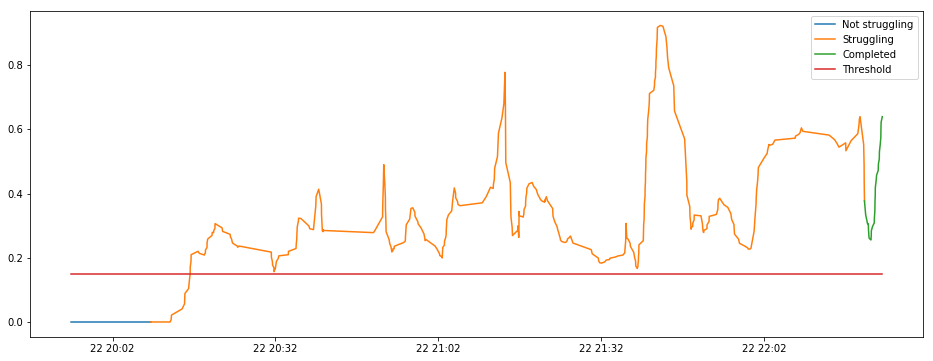

In [48]:
plt.figure(figsize=(16,6))
plt.plot(df[not_debugging].scaled_max_smoothed, label='Not struggling')
plt.plot(df[debugging].scaled_max_smoothed, label='Struggling')
plt.plot(df[completed].scaled_max_smoothed, label='Completed')
plt.plot(df.line, label='Threshold')
plt.legend()

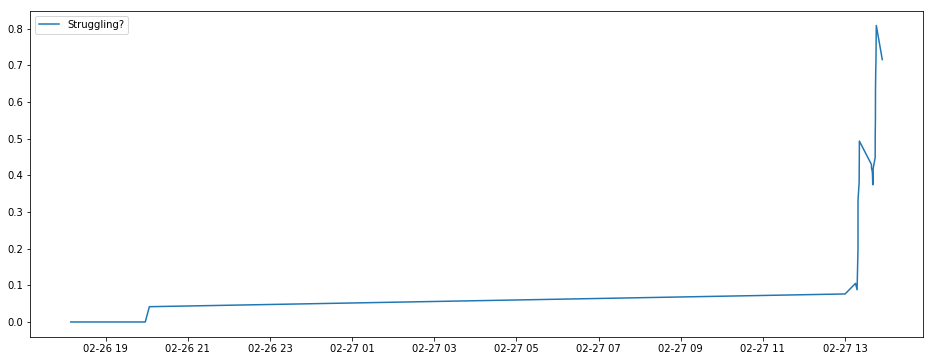

In [18]:
plt.figure(figsize=(16,6))
plt.plot(df.scaled_max_smoothed, label='Struggling?')
plt.legend()

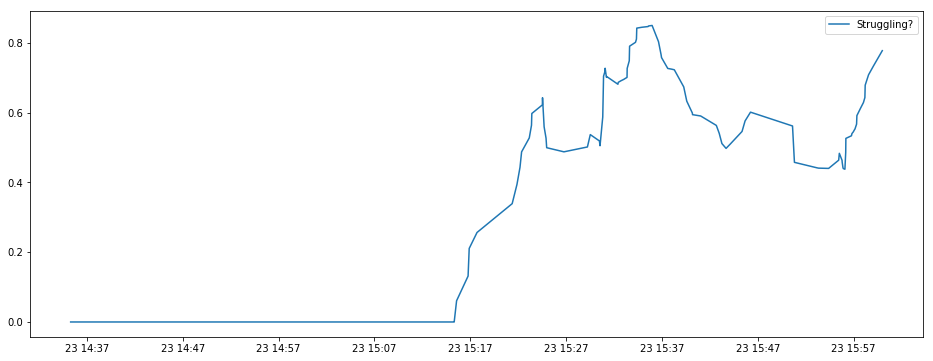

In [31]:
plt.figure(figsize=(16,6))
plt.plot(df.scaled_max_smoothed, label='Struggling?')
plt.legend()

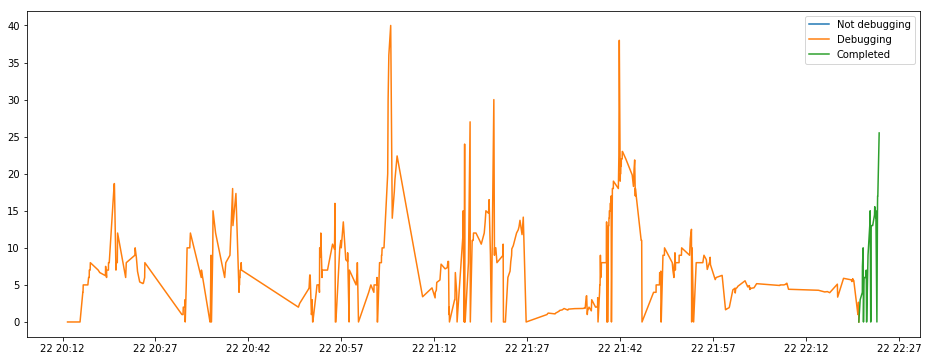

In [48]:
df['acc_div_point_mult_runs'] = df.acc_div_point * df.runs_last_5mins
plt.figure(figsize=(16,6))
plt.plot(df[not_debugging].acc_div_point_mult_runs, label='Not debugging')
plt.plot(df[debugging].acc_div_point_mult_runs, label='Debugging')
plt.plot(df[completed].acc_div_point_mult_runs, label='Completed')
plt.legend()

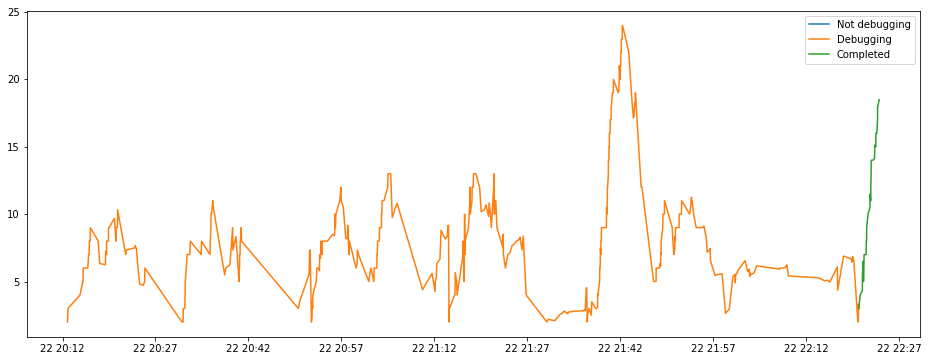

In [49]:
df['acc_div_point_pluss_runs'] = df.acc_div_point + df.runs_last_5mins
plt.figure(figsize=(16,6))
plt.plot(df[not_debugging].acc_div_point_pluss_runs, label='Not debugging')
plt.plot(df[debugging].acc_div_point_pluss_runs, label='Debugging')
plt.plot(df[completed].acc_div_point_pluss_runs, label='Completed')
plt.legend()

## Relative time

In [16]:
df['Original_timestamp'] = df.index

In [20]:
df = df.set_index(df.Relative_time)

## Experiment 2, Part 1

In [ ]:
df['TotalRuns_ma10'] = df.TotalRuns.rolling(10).mean()

In [ ]:
df.TotalRuns_ma10

In [ ]:
df['Character_diff_ma10'] = df.character_diff1.ffill().rolling(10, min_periods=10).mean()

In [ ]:
df.Character_diff_ma10

In [ ]:
df['hypotese'] = df.Character_diff_ma10 / df.TotalRuns_ma10

In [ ]:
df.hypotese['2017-02-22 20:21:00':'2017-02-22 20:40:00']

In [ ]:
df_slice = df['2017-02-22 20:21:00':'2017-02-22 20:40:00'].copy()

In [ ]:
df_slice.hypotese.replace(np.inf,
                          df_slice.hypotese.replace(np.inf, 0).max() * 2,
                          inplace=True)

In [ ]:
df_slice.hypotese

In [ ]:
#plt.plot(df_slice.hypotese)
df_slice.hypotese.plot()

## Experiment #1

In [ ]:
df

In [ ]:
df['TotalRuns'] = df.JunitTest + df.Launch

In [ ]:
df['TotalRuns_ma10'] = df.TotalRuns.rolling(10).mean()

In [ ]:
df.TotalRuns_ma10

In [ ]:
df['SizeMeasure1_change'] = df.SizeMeasure1.diff().abs()

In [ ]:
df.SizeMeasure1_change

In [ ]:
df['SizeMeasure1_change_ma10'] = df.SizeMeasure1_change.rolling(10).mean()

In [ ]:
df.SizeMeasure1_change_ma10

In [ ]:
df['hypotese'] =df.SizeMeasure1_change_ma10 / df.TotalRuns_ma10

In [ ]:
df.hypotese['2017-02-22 20:21:00':'2017-02-22 20:40:00']

In [ ]:
df_slice = df['2017-02-22 20:21:00':'2017-02-22 20:40:00'].copy()

In [ ]:
df_slice.hypotese.replace(np.inf,
                          df_slice.hypotese.replace(np.inf, 0).max() * 2,
                          inplace=True)

In [ ]:
df_slice.hypotese

In [ ]:
df_slice.hypotese.plot()

In [ ]:
from matplotlib.dates import AutoDateFormatter, AutoDateLocator

In [ ]:
fig, ax = plt.subplots()
xtick_locator = AutoDateLocator(minticks=6)
xtick_formatter = AutoDateFormatter(xtick_locator, defaultfmt='%H:%M')
ax.xaxis.set_major_locator(xtick_locator)
ax.xaxis.set_major_formatter(xtick_formatter)
ax.plot(df_slice2)
plt.show()

## Possible features:

### Changes in size measure divived by how many times the code has been run
Using a moving average of 10 of both the difference in size measure and the total runs (Junit + Launch)

### Changes in size measure since last run.
Accumulate the size measure changes (diff) and reset every time we reach a run (either Junit or Launch)

### Time since last run in relative time (?)